In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import layers
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

Constants

In [ ]:
EPOCHS = 10
LAMBDA = 100
latent_dim = 64
BATCH_SIZE = 8
BUFFER_SIZE = 1000
vocab_size = 5000 
maxlen = 25
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

Downloading Dataset

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 263s 0us/step


In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = image / 255
    return image, image_path

In [ ]:
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = img

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24015, 24015, 6004, 6004)

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
img_, capti_ = next(iter(dataset))

In [ ]:
def _decode_sequence(caption):
  lst = []
  cap = caption.numpy()
  for i in range(len(cap)):
    lst.append(tokenizer.get_vocabulary()[cap[i]])
  return ' '.join(lst)

<start> man on skateboard looking ahead to his next move <end>                                       


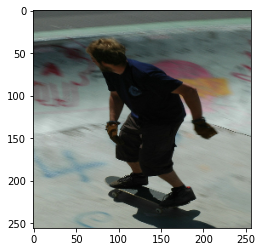

In [ ]:
print(_decode_sequence(capti_[1]))
plt.imshow(img_[1])

Tokenization

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
def decode_sequence(encoded_text):
  lst = []
  for i in encoded_text[0]:
    lst.append(tokenizer.index_word[i])
  return ' '.join(lst)

In [ ]:
def tokenize_sequence(sequence):
  tokezied =  tokenizer.texts_to_sequences(sequence)


Building the Dataset

In [ ]:
@tf.function
def load(image_path):
  print(tf.convert_to_tensor(image_path).numpy())
  cap = image_path_to_caption[image_path.numpy()]

  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (256, 256))
  image = image / 255
  

  return image, cap

In [ ]:
dataset = tf.data.Dataset.list_files("/content/train2014/*.jpg")
dataset = dataset.map(load, num_parallel_calls=tf.data.AUTOTUNE)

AttributeError: ignored

In [ ]:
captions_dataset = tf.data.Dataset.from_tensor_slices(cap_vector)
captions_dataset = captions_dataset.batch(BATCH_SIZE, drop_remainder=True)

[]


NameError: ignored

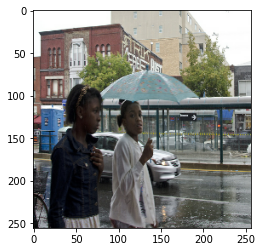

In [ ]:
image, caption = next(iter(dataset))

plt.imshow(image)
print(caption.numpy())
print(decode_sequence(caption))

Resudial Layers

In [ ]:
class ResidualDownSample(tf.keras.layers.Layer):
    def __init__(self, filter=32):
        super(ResidualDownSample, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filter, (3, 3), padding = 'same', strides = (2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filter, (3, 3), padding = 'same', strides = (1, 1))

        self.skip_conv= tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))
        
        self.bn1 = tf.keras.layers.BatchNormalization(axis=3)
        self.bn2 = tf.keras.layers.BatchNormalization(axis=3)

    def call(self, x):
        skip = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = self.conv2(x)
        x = self.bn1(x)
        x = tf.keras.layers.Activation('relu')(x)

        skip = self.skip_conv(skip)

        x = tf.keras.layers.Add()([x, skip])     
        x = tf.keras.layers.Activation('relu')(x)
        return x


class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self, filter=32):
        super(ResidualLayer, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filter, (3, 3), padding = 'same', strides = (1, 1))
        self.conv2 = tf.keras.layers.Conv2D(filter, (3, 3), padding = 'same', strides = (1, 1))

        self.skip_conv= tf.keras.layers.Conv2D(filter, (1,1), strides = (1, 1))
        
        self.bn1 = tf.keras.layers.BatchNormalization(axis=3)
        self.bn2 = tf.keras.layers.BatchNormalization(axis=3)

    def call(self, x):
        skip = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = self.conv2(x)
        x = self.bn1(x)
        x = tf.keras.layers.Activation('relu')(x)

        skip = self.skip_conv(skip)

        x = tf.keras.layers.Add()([x, skip])     
        x = tf.keras.layers.Activation('relu')(x)
        return x
  

class Upsample(tf.keras.layers.Layer):
    def __init__(self, filter=32):
        super(Upsample, self).__init__()
        self.convT = layers.Conv2DTranspose(filter, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn = layers.BatchNormalization()

    def call(self, x):
        x = self.convT(x)
        x = self.bn(x)
        x = tf.keras.layers.LeakyReLU()(x)

        return x
  

Upsample and Downsample layers

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Variational Auto Encoder

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim

    self.encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
        ResidualDownSample(32),
        ResidualDownSample(64),  
        ResidualDownSample(128),
        ResidualDownSample(256),
        ResidualDownSample(512),
        ResidualDownSample(512),
        ResidualDownSample(512),
        ResidualDownSample(512),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(latent_dim + latent_dim),
      ])

    self.decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
        tf.keras.layers.Dense(units=1*1*512, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(1, 1, 512)),
        Upsample(512),
        Upsample(512),
        Upsample(512),
        Upsample(256),
        Upsample(256),
        Upsample(128),
        Upsample(64),
        Upsample(32),
        layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh') 
      ])

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
  
  def __call__(self, x, training=True):
    mu, log = self.encode(x)
    z = self.reparameterize(mu, log)
    out = self.decode(z)

    return out

Pix2Pix

In [ ]:
def Pix2Pix():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Discrimiator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Losses

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def _generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_vae_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x), x_logit

Train step

In [ ]:
@tf.function
def vae_train_step(generator, discriminator, generator_optimizer, discriminator_optimizer, images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      vae_loss, generated_images = compute_vae_loss(generator, images)

      disc_real_output = discriminator([images, images], training=True)
      disc_generated_output = discriminator([images, generated_images], training=True)

      gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, generated_images, images)
      disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

      total_loss = gen_total_loss * LAMBDA + vae_loss

    gradients_of_generator = gen_tape.gradient(total_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

    return gen_total_loss, vae_loss, gen_total_loss
  

@tf.function
def unet_train_step(images, vae_out):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = pix2pix_generator(vae_out)

      disc_real_output = pix2pix_discriminator([vae_out, images], training=True)
      disc_generated_output = pix2pix_discriminator([images, generated_images], training=True)

      gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, generated_images, images)
      disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          pix2pix_generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                              pix2pix_discriminator.trainable_variables)

    pix2pix_generator_optimizer.apply_gradients(zip(generator_gradients,
                                          pix2pix_generator.trainable_variables))
    pix2pix_discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    return gen_total_loss, gen_total_loss, gen_total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
discriminator = Discriminator()
vae = CVAE(latent_dim)

In [ ]:
for epoch in range(1, 10000):
  start_time = time.time()
  for train_x, _ in dataset:
    total_loss, gen_loss, vae_loss = vae_train_step(vae, discriminator, generator_optimizer, discriminator_optimizer, train_x)
    print('{} {}'.format(total_loss * 100, gen_loss))
  end_time = time.time()

  print('Epoch: {}/{} - Loss: {} - time taken: {}(s)'
        .format(epoch, EPOCHS, total_loss, end_time - start_time))

5203.86083984375 135493.6875
4675.65673828125 135118.46875


KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 256, 256, 3)


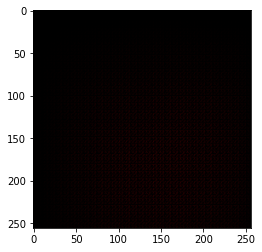

In [ ]:
index = 2
mu, log = vae.encode(train_x)
z = vae.reparameterize(mu, log)
out = vae.decode(z)
print(out.shape)
plt.imshow(out[index].numpy().reshape(256, 256, 3))

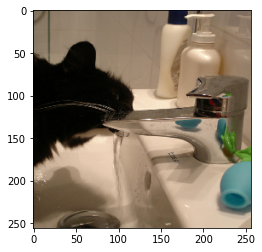

In [ ]:
plt.imshow(train_x[index])

In [ ]:
vae.save_weights(f'cvae-{latent_dim}-latent_dim.h5')
discriminator.save_weights('cvae-discriminator.h5')

In [ ]:
pix2pix_generator = Pix2Pix()
pix2pix_discriminator = Discriminator()
pix2pix_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
pix2pix_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
for epoch in range(1, 10000):
  start_time = time.time()
  for train_x in dataset:
    _, vae_out = compute_vae_loss(vae, train_x)
    total_loss, gen_loss, vae_loss = unet_train_step(train_x, vae_out)
  end_time = time.time()

  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, total_loss, end_time - start_time))

KeyboardInterrupt: ignored

In [ ]:
train_x = next(iter(dataset))

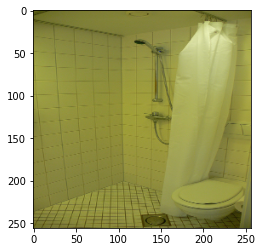

In [ ]:
index = 7
plt.imshow(train_x[index])

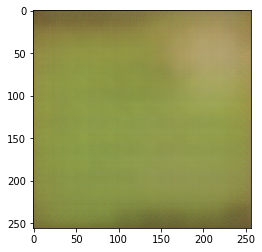

In [ ]:
mu, log = vae.encode(train_x)
z = vae.reparameterize(mu, log)
out = vae.decode(z)
out = pix2pix_generator(out)
plt.imshow(out[index].numpy().reshape(256, 256, 3))

In [ ]:
 vae.save_weights("vae.h5")
discriminator.save_weights('disc.h5')

Transformer & Text processing

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
bert_optimizer = tf.keras.optimizers.Adam(2e-4)

In [ ]:
def build_bert(maxlen, vocab_size, embed_dim, num_heads, ff_dim):
  
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

  inputs = layers.Input(shape=(maxlen,))
  x = embedding_layer(inputs)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(20, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(2, activation="softmax")(x)

  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
@tf.function
def bert_train_step(cvae, images, captions):
    with tf.GradientTape() as tape:
      code = bert(captions)
      z = cvae.reparametize(code)
      generated_images = cvae.decode(z)

      l1_loss = tf.reduce_mean(tf.abs(images - generated_images))

    gradients = tape.gradient(l1_loss, bert.trainable_variables)
    bert_optimizer.apply_gradients(zip(gradients, bert.trainable_variables))
    
    return l1_loss

In [ ]:
plt.imshow(train_x[140].numpy().reshape(64,64))

In [ ]:
from tensorflow.keras import layers

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model

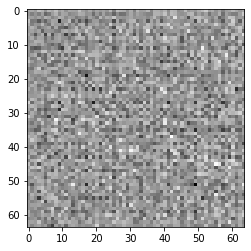

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:

# def make_discriminator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', input_shape=[64, 64, 1], use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.2))

#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.2))

#     model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.2))

#     model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.2))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))

#     return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                      input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00050936]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def gradient_penalty(batch_size, real_images, fake_images):
    # Get the interpolated image
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [ ]:
Lambda = 10
@tf.function
def train_step(images,captions,batch_size):
  with tf.device('/device:GPU:0'): 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      noise = tf.random.normal([batch_size, 100])
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      gp = gradient_penalty(batch_size, images, generated_images)
      disc_loss = disc_loss + gp * Lambda

    tf.print(gen_loss,disc_loss)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
from IPython.display import Image, display


def train(epochs):
  for epoch in range(epochs):
    start = time.time()
    batch_size = 1000
    for i in range(len(train_captions)//batch_size):
      print(f'batch no {i + 1}')
      image_batch = train_images[i*batch_size:(i+1)*batch_size]
      caption_batch = np.array(train_captions[i*batch_size:(i+1)*batch_size])
      train_step(image_batch, caption_batch,batch_size)

    print ('Time for epoch {} is {}(s)'.format(epoch + 1, time.time()-start))
    if epoch % 1 == 0:
      # index = np.random.randint(1,len(train_captions))
      noise = tf.random.normal([1, 100])
      img = np.array(generator(noise))
      # print(decode_sequence([train_captions[index]]))
      img = img.reshape(64,64)
      plt.imshow(img)
      plt.savefig('fig.png',cmap='gray')
      display(Image("/content/fig.png"))


batch no 1
0.424657 7.75713444
batch no 2
0.42001307 7.75286245
batch no 3
0.41704151 7.74409151
batch no 4
0.412132353 7.73519
batch no 5
0.407688618 7.72843075
batch no 6
0.402459 7.72417068
batch no 7
0.398503065 7.71274328
batch no 8
0.394517332 7.70304775
batch no 9
0.390825361 7.69060707
batch no 10
0.387460887 7.6779213
batch no 11
0.388043582 7.65686321
batch no 12
0.387866735 7.63787699
batch no 13
0.39225477 7.61124134
batch no 14
0.398005545 7.58453
batch no 15
0.407703191 7.53819466
batch no 16
0.420242 7.49537706
batch no 17
0.434862763 7.44895029
batch no 18
0.451195806 7.39472485
batch no 19
0.468595415 7.35740614
batch no 20
0.489234686 7.36441898
batch no 21
0.502204597 7.34577608
batch no 22
0.506890118 7.36659622
batch no 23
0.501936376 7.26116657
batch no 24
0.494108438 7.33930063
batch no 25
0.478385895 7.3095541
batch no 26
0.465872318 7.252635
batch no 27
0.459107965 7.26441193
batch no 28
0.451651782 7.25898266
batch no 29
0.442943722 7.25273561
batch no 30
0.44

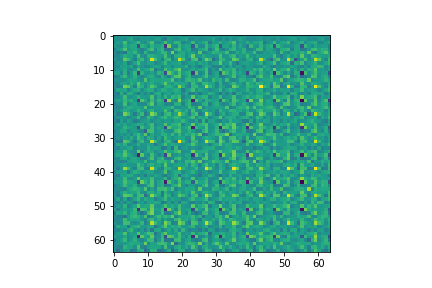

batch no 1
0.444241285 7.22930908
batch no 2
0.444784462 7.21124172
batch no 3
0.448199809 7.19207859
batch no 4
0.458447367 7.16166544
batch no 5
0.467601061 7.11194611
batch no 6
0.478296965 7.10156441
batch no 7
0.4904975 7.03014278
batch no 8
0.501900852 7.02261686
batch no 9
0.517125905 6.95088577
batch no 10
0.531245053 6.95447588
batch no 11
0.540713847 6.92892265
batch no 12
0.541404486 6.90316582
batch no 13
0.534368277 6.90180397
batch no 14
0.522590637 6.96074486
batch no 15
0.496329248 6.91459322
batch no 16
0.462790728 6.92959213
batch no 17
0.421141595 6.97152758
batch no 18
0.377136 7.06141424
batch no 19
0.331060886 7.16414404
batch no 20
0.293358415 7.24040079
batch no 21
0.267882764 7.27087736
batch no 22
0.256421655 7.30227661
batch no 23
0.25192672 7.30022
batch no 24
0.255280226 7.28397226
batch no 25
0.258362889 7.25576973
batch no 26
0.266183138 7.20239067
batch no 27
0.27477029 7.21402502
batch no 28
0.276628464 7.18678188
batch no 29
0.278404444 7.15926313
batc

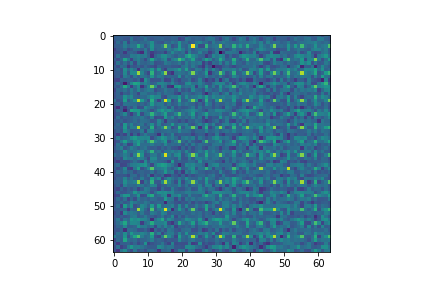

batch no 1
0.270805836 7.1785984
batch no 2
0.265847 7.13246298
batch no 3
0.262208581 7.1264205
batch no 4
0.26014 7.18318462
batch no 5
0.258717895 7.13489199
batch no 6
0.258959115 7.17480135
batch no 7
0.262504935 7.09700155
batch no 8
0.26729238 7.08667
batch no 9
0.272365898 7.04260349
batch no 10
0.276970983 7.11558533
batch no 11
0.27920112 7.03781033
batch no 12
0.278348505 7.01406384
batch no 13
0.279877216 7.07542515
batch no 14
0.277017444 7.09617376
batch no 15
0.27098608 7.06299114
batch no 16
0.263527721 7.02152729
batch no 17
0.259450942 7.02319098
batch no 18
0.259261668 7.06134892
batch no 19
0.263928354 7.04852438
batch no 20
0.26888445 7.05812693
batch no 21
0.276013345 6.93287134
batch no 22
0.282498151 6.86930132
batch no 23
0.295264125 6.86654758
batch no 24
0.30924 6.91681671
batch no 25
0.320447534 6.79519081
batch no 26
0.32552126 6.81882858
batch no 27
0.317099035 6.91683292
batch no 28
0.298701346 6.82767153
batch no 29
0.28215307 6.84746075
batch no 30
0.26

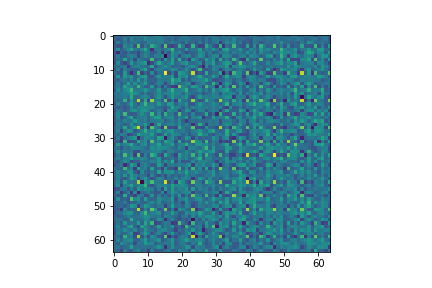

batch no 1
0.261744916 6.91810083
batch no 2
0.259033352 6.90883255
batch no 3
0.260055214 6.89740562
batch no 4
0.266621739 6.84298325
batch no 5
0.276156694 6.81269121
batch no 6
0.288401335 6.77655792
batch no 7
0.30587092 6.65822315
batch no 8
0.327469289 6.73568201
batch no 9
0.331876218 6.59945393
batch no 10
0.336200595 6.74493647
batch no 11
0.332682252 6.67425
batch no 12
0.323361516 6.60678339
batch no 13
0.322807878 6.67081928
batch no 14
0.318019956 6.74254084
batch no 15
0.313587517 6.66238594
batch no 16
0.315079689 6.69539738
batch no 17
0.320139319 6.60622501
batch no 18
0.334743887 6.46988153
batch no 19
0.357786328 6.48975706
batch no 20
0.383541524 6.47504616
batch no 21
0.410459191 6.35650826
batch no 22
0.446818441 6.18964386
batch no 23
0.494209528 6.15668535
batch no 24
0.553468823 6.11763191
batch no 25
0.595877886 5.93192387
batch no 26
0.634349704 5.92796
batch no 27
0.662915 5.93856239
batch no 28
0.677467406 5.7993536
batch no 29
0.681078792 5.88158321
batch

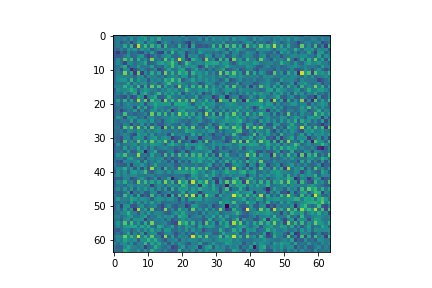

batch no 1
0.629599035 5.75391579
batch no 2
0.620427251 5.7443161
batch no 3
0.62314862 5.76483583
batch no 4
0.635312438 5.80038071
batch no 5
0.653012812 5.70661688
batch no 6
0.688692 5.58894348
batch no 7
0.731901467 5.4799161
batch no 8
0.788967252 5.50863457
batch no 9
0.858804643 5.38244104
batch no 10
0.926747382 5.56838751
batch no 11
0.904552579 5.36739922
batch no 12
0.824103177 5.31115246
batch no 13
0.767998397 5.31847382
batch no 14
0.72629 5.45549154
batch no 15
0.683204353 5.32997608
batch no 16
0.664330542 5.29909706
batch no 17
0.672864795 5.24053621
batch no 18
0.710745633 5.26337528
batch no 19
0.772534788 5.1631
batch no 20
0.864766121 5.09228
batch no 21
0.964172542 4.85912323
batch no 22
1.09728515 4.73731279
batch no 23
1.2474364 4.56302691
batch no 24
1.40361691 4.65590763
batch no 25
1.51573288 4.46506786
batch no 26
1.63483095 4.27434635
batch no 27
1.71001613 4.32141781
batch no 28
1.6766119 4.23968315
batch no 29
1.58886099 4.40306568
batch no 30
1.3967647

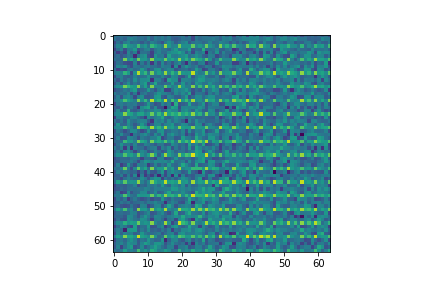

batch no 1
1.25356519 4.22923899
batch no 2
1.15842938 4.30108404
batch no 3
1.10244191 4.26672554
batch no 4
1.1018858 4.13727951
batch no 5
1.12970185 4.042099
batch no 6
1.19221461 4.1194253
batch no 7
1.27224374 3.92557955
batch no 8
1.39187586 3.89817953
batch no 9
1.50520551 3.61809564
batch no 10
1.64140415 3.84405613
batch no 11
1.56888509 3.68045974
batch no 12
1.38529241 3.46395159
batch no 13
1.24736702 3.68730688
batch no 14
1.10889673 3.97731495
batch no 15
0.925533891 3.8139956
batch no 16
0.777887344 3.82052803
batch no 17
0.677729785 3.84168291
batch no 18
0.667376041 3.85470033
batch no 19
0.726728 3.68760014
batch no 20
0.867216587 3.6102941
batch no 21
1.05223083 3.20703411
batch no 22
1.33215499 2.98240209
batch no 23
1.68310308 2.90279555
batch no 24
2.03950191 3.48806381
batch no 25
1.87189186 2.83376312
batch no 26
1.60796857 2.82401395
batch no 27
1.38151515 2.84445405
batch no 28
1.22193348 2.92283297
batch no 29
1.14948726 2.99393272
batch no 30
1.124488 3.002

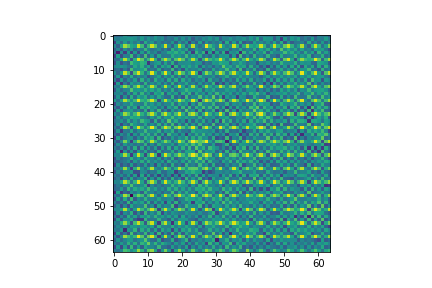

batch no 1
1.17670536 2.86714888
batch no 2
1.30307102 2.74988413
batch no 3
1.49608684 2.63809824
batch no 4
1.75147903 2.64195299


In [ ]:
train(200)

In [ ]:
 
#giga dis
# gen = 13.7919235 dis = 6.29117312e-06
# Time for epoch 100 is 14.090641260147095 sec

#mid dis
# 10.242816 3.61115272e-05
# Time for epoch 100 is 8.079702138900757(s)

# mid dis with grad punishment
# 9.26017284 0.00196946063
# Time for epoch 100 is 12.681172609329224(s)

#giga dis with grad punishemnt
# 36.3338852 0.02767675
# Time for epoch 100 is 27.41854238510132(s)

<start> a woman and a girl sitting at a table eating <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


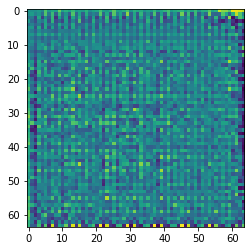

In [ ]:
img = np.array(generator(np.expand_dims(np.array(train_captions[5432]), axis=0)))
print(decode_sequence([train_captions[5432]]))
img = img.reshape(64,64)
plt.imshow(img)

<start> a boy wearing a tie and checkered pants on the porch of a house <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


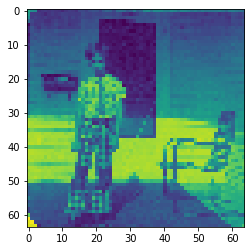

In [ ]:
plt.imshow(train_images[432].reshape(64,64))
print(decode_sequence([train_captions[432]]))